<a href="https://colab.research.google.com/github/scheung97/EECE5639_ComputerVision/blob/main/p3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# Northeastern University
# EECE5639 Computer Vision

# Spenser Cheung & Tim Liming

# Project 3

import cv2 
import numpy as np 
import os
from matplotlib import pyplot as plt
from IPython.display import clear_output
from time import sleep
from scipy import ndimage
from scipy import signal

from google.colab.patches import cv2_imshow
from google.colab import drive


In [1]:
!python3 --version
!pip install opencv-python==3.4.2.17
!pip install opencv-contrib-python==3.4.2.17

Python 3.7.12
     |████████████████████████████████| 25.0 MB 2.1 MB/s 
  Attempting uninstall: opencv-python
    Found existing installation: opencv-python 4.1.2.30
    Uninstalling opencv-python-4.1.2.30:
      Successfully uninstalled opencv-python-4.1.2.30
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.
     |████████████████████████████████| 30.6 MB 58.3 MB/s 
  Attempting uninstall: opencv-contrib-python
    Found existing installation: opencv-contrib-python 4.1.2.30
    Uninstalling opencv-contrib-python-4.1.2.30:
      Successfully uninstalled opencv-contrib-python-4.1.2.30


In [3]:
# Mount Google Drive in Google Colab

# Public P3 folder link: 
# https://drive.google.com/drive/folders/1y8caBKDzvhXgwu-AbLbjtGWBXKbywQlG?usp=sharing

drive.mount('/content/gdrive', force_remount=True)

P3_path = "/content/gdrive/MyDrive/EECE5639_P3"

Mounted at /content/gdrive


In [4]:
# i. Read in two images.

# cast
p3_files = [filename for filename in sorted(os.listdir(P3_path)) if os.path.isfile(os.path.join(P3_path, filename))]

cast_color = []
cast_gray = []
for i in range(0, len(p3_files)-2): 
    img = cv2.imread(os.path.join(P3_path, p3_files[i]))
    cast_color.append(img)
    gray_img = cv2.cvtColor(img, cv2.COLOR_BGRA2GRAY)
    cast_gray.append(gray_img)

cast_color = np.array(cast_color)
print(cast_color.shape)
cast_gray = np.array(cast_gray)
print(cast_gray.shape)

(2, 384, 576, 3)
(2, 384, 576)


In [5]:
# i. Read in two images.

# cones
p3_files = [filename for filename in sorted(os.listdir(P3_path)) if os.path.isfile(os.path.join(P3_path, filename))]

cones_color = []
cones_gray = []
for i in range(2, len(p3_files)): 
    img = cv2.imread(os.path.join(P3_path, p3_files[i]))
    cones_color.append(img)
    gray_img = cv2.cvtColor(img, cv2.COLOR_BGRA2GRAY)
    cones_gray.append(gray_img)

cones_color = np.array(cones_color)
print(cones_color.shape)
cones_gray = np.array(cones_gray)
print(cones_gray.shape)

(2, 375, 450, 3)
(2, 375, 450)


Reduced Images:


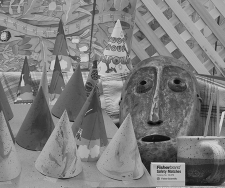

(188, 225)
----------------------------------


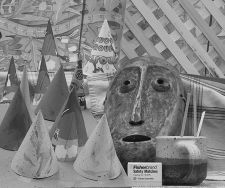

(188, 225)
----------------------------------


In [6]:
# i. Read in two images. (Note: if the images are large, you may want to reduce
# their size to keep running time reasonable! Document in your report the scale
# factor you used.)

#use_cast = True
use_cast = False
if use_cast:
    #img1, img2 = np.random.default_rng().choice(cast_color, 2, replace=False)
    img1 = cast_gray[0]
    img2 = cast_gray[1]
else:
    #img1, img2 = np.random.default_rng().choice(cones_color, 2, replace=False)
    img1 = cones_gray[0]
    img2 = cones_gray[1]

#print('Original Images:')
#cv2_imshow(img1)
#print('--------------------------------------------------------------')
#cv2_imshow(img2)
#print('--------------------------------------------------------------')

scale = 0.5
r_img1 = cv2.resize(img1, None, fx=scale, fy=scale, interpolation=cv2.INTER_LINEAR)
r_img2 = cv2.resize(img2, None, fx=scale, fy=scale, interpolation=cv2.INTER_LINEAR)

print('Reduced Images:')
cv2_imshow(r_img1)
print(r_img1.shape)
print('----------------------------------')
cv2_imshow(r_img2)
print(r_img2.shape)
print('----------------------------------')


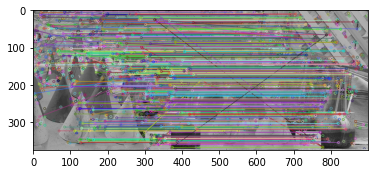

In [7]:
# 1. Find interesting features and correspondences between the left and right 
# images. You can use the CORNERS and NCC algorithms that you wrote/used for 
# the second project or SIFT features and descriptors. Display your results in 
# the same way you did for project 2 i.e. by connecting corresponding features 
# with a line. Using lines of different colors for different points makes it 
# easier to visualize the results.

# https://opencv24-python-tutorials.readthedocs.io/en/latest/py_tutorials/py_feature2d/py_matcher/py_matcher.html


# Initiate SIFT detector
sift = cv2.xfeatures2d.SIFT_create()

# find the keypoints and descriptors with SIFT
kp1, des1 = sift.detectAndCompute(img1, None)
kp2, des2 = sift.detectAndCompute(img2, None)

# FLANN parameters
FLANN_INDEX_KDTREE = 0
index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
search_params = dict(checks=50)   # or pass empty dictionary

flann = cv2.FlannBasedMatcher(index_params,search_params)

matches = flann.knnMatch(des1,des2,k=2)

# Need to draw only good matches, so create a mask
matchesMask = [[0,0] for i in range(len(matches))]

good = []
pts1 = []
pts2 = []

# ratio test as per Lowe's paper
for i,(m,n) in enumerate(matches):
    if m.distance < 0.8*n.distance:
        matchesMask[i]=[1,0]
        good.append(m)
        pts2.append(kp2[m.trainIdx].pt)
        pts1.append(kp1[m.queryIdx].pt)

img3 = cv2.drawMatchesKnn(img1, kp1, img2, kp2, matches, None,
                          matchesMask = matchesMask, flags = 0)

plt.imshow(img3,)
plt.show()

[[ 9.31322575e-10  1.94132328e-04  5.56106567e-02]
 [-1.74582005e-04  9.88505781e-06 -2.36595085e+12]
 [-5.61523438e-02  2.36595085e+12  1.00000000e+00]]
----------------------------------


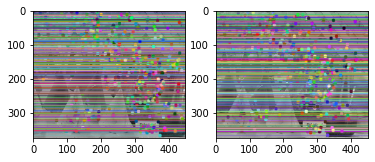

In [8]:
# 2. Write a program to estimate the Fundamental Matrix for each pair using the
# correspondences above and RANSAC to eliminate outliers. Display the inlier 
# correspondences in the same way as above.

# https://opencv24-python-tutorials.readthedocs.io/en/latest/py_tutorials/py_calib3d/py_epipolar_geometry/py_epipolar_geometry.html

def drawlines(img_1,img_2, lines, pts1,pts2):
    r,c = img_1.shape
    img_1 = cv2.cvtColor(img_1,cv2.COLOR_GRAY2BGR)
    img_2 = cv2.cvtColor(img_2,cv2.COLOR_GRAY2BGR)

    for r,pt1,pt2 in zip(lines,pts1,pts2):
        color = tuple(np.random.randint(0,255,3).tolist())
        x0,y0 = map(int, [0, -r[2]/r[1] ])
        x1,y1 = map(int, [c, -(r[2]+r[0]*c)/r[1] ])
        img_1 = cv2.line(img_1, (x0,y0), (x1,y1), color,1)
        img_1 = cv2.circle(img_1,tuple(pt1),5,color,-1)
        img_2 = cv2.circle(img_2,tuple(pt2),5,color,-1)

    return img_1,img_2


pts1 = np.int32(pts1)
pts2 = np.int32(pts2)
F, mask = cv2.findFundamentalMat(pts1, pts2, cv2.FM_RANSAC)
print(F)
print('----------------------------------')

# We select only inlier points
pts1 = pts1[mask.ravel()==1]
pts2 = pts2[mask.ravel()==1]

# Find epilines corresponding to points in right image (second image) and
# drawing its lines on left image
lines1 = cv2.computeCorrespondEpilines(pts2.reshape(-1,1,2), 2,F)
lines1 = lines1.reshape(-1,3)
img5,img6 = drawlines(img1,img2,lines1,pts1,pts2)

# Find epilines corresponding to points in left image (first image) and
# drawing its lines on right image
lines2 = cv2.computeCorrespondEpilines(pts1.reshape(-1,1,2), 1,F)
lines2 = lines2.reshape(-1,3)
img3,img4 = drawlines(img2,img1,lines2,pts2,pts1)

plt.subplot(121),plt.imshow(img5)
plt.subplot(122),plt.imshow(img3)
plt.show()

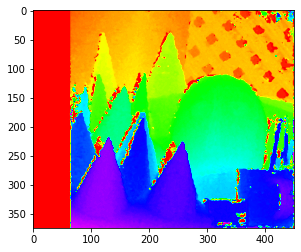

In [9]:
# 3. Compute a dense disparity map using the Fundamental matrix to help reduce 
# the search space. The output should be three images, one image with the 
# vertical disparity component, and another image with the horizontal disparity 
# component, and a third image representing the disparity vector using color, 
# where the direction of the vector is coded by hue, and the length of the 
# vector is coded by saturation. For gray scale display, scale the disparity 
# values so the lowest disparity is 0 and the highest disparity is 255.

# https://opencv24-python-tutorials.readthedocs.io/en/latest/py_tutorials/py_calib3d/py_depthmap/py_depthmap.html
# https://fossies.org/linux/opencv/samples/python/stereo_match.py

# Cast
#min_disp = 16
#num_disp = 80-min_disp

# Cones
min_disp = 16
num_disp = 64-min_disp

stereo = cv2.StereoSGBM_create(minDisparity = min_disp, 
                               numDisparities = num_disp, blockSize = 1)
disp = stereo.compute(img1, img2).astype(np.float32) / 16.0
'''
mod_disp = np.zeros_like(disp)
for i in range(disp.shape[0]):
    for j in range(disp.shape[1]):
        if disp[i][j] < 16.0: 
            mod_disp[i][j] = 0
        elif disp[i][j] < 32.0:
            mod_disp[i][j] = 16
        elif disp[i][j] < 48.0:
            mod_disp[i][j] = 32
        elif disp[i][j] < 64.0:
            mod_disp[i][j] = 48

print(np.min(disp))
print(np.max(disp))
print(np.min(mod_disp))
print(np.max(mod_disp))
plt.imshow(mod_disp, 'gray')
'''

#plt.imshow(disp, 'gray')
plt.imshow(disp, 'hsv')

plt.show()